In [54]:
# Import QICK libraries and extras

from qick import *

from tqdm import tqdm
from scipy.optimize import curve_fit

import numpy as np

%pylab inline
from qick.rfboard import RFQickSoc216V1


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/nexusadmin/anaconda3/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['angle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


ValueError: mutable default <class 'pynqmetadata.models.vlnv.Vlnv'> for field vlnv is not allowed: use default_factory

In [55]:
from qick.pyro import make_proxy
soc, soccfg = make_proxy(ns_host="pynq216-3.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
print(soccfg)


Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_1d059f5adc734a7fa46b20144cabb426@131.225.192.214:45511

QICK configuration:

	Board: ZCU216

	Software version: 0.2.228
	Firmware timestamp: Wed Jan 31 08:18:41 2024

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	16 signal generator channels:
	0:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 3 is 3_2

In [81]:
#helper functions
def hist_ssf(data=None, plot=True, ran=1.0):
    
    ig = data[0]
    qg = data[1]
    ie = data[2]
    qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

#     if plot==True:
#         fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
#         fig.tight_layout()

#         axs[0].scatter(ig, qg, label='g', color='b', marker='*')
#         axs[0].scatter(ie, qe, label='e', color='r', marker='*')
#         axs[0].scatter(xg, yg, color='k', marker='o')
#         axs[0].scatter(xe, ye, color='k', marker='o')
#         axs[0].set_xlabel('I (a.u.)')
#         axs[0].set_ylabel('Q (a.u.)')
#         axs[0].legend(loc='upper right')
#         axs[0].set_title('Unrotated')
#         axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -np.arctan2((ye-yg),(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*np.cos(theta) - qg*np.sin(theta)
    qg_new = ig*np.sin(theta) + qg*np.cos(theta) 
    ie_new = ie*np.cos(theta) - qe*np.sin(theta)
    qe_new = ie*np.sin(theta) + qe*np.cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)
    
    #print(xg, xe)
    
    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        print('hi')
#         axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
#         axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
#         axs[1].scatter(xg, yg, color='k', marker='o')
#         axs[1].scatter(xe, ye, color='k', marker='o')    
#         axs[1].set_xlabel('I (a.u.)')
#         axs[1].legend(loc='lower right')
#         axs[1].set_title('Rotated')
#         axs[1].axis('equal')

#         """X and Y ranges for histogram"""
        
#         ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
#         ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
#         axs[2].set_xlabel('I(a.u.)')       
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum())))
    tind=contrast.argmax()
    threshold=binsg[tind]
    fid = contrast[tind]
#    axs[2].set_title(f"Fidelity = {fid*100:.2f}%")

    return fid, threshold, theta

## Set RFBoard Attenuation

In [57]:
ch_config = {"res_ch"      : 15, #specialized MUX gen
        "q1_ch"       : 4,
        "q2_ch"       : 5,
        "q3_ch"       : 6,
        "q4_ch"       : 7,
        "ro_ch"       :[0, 1, 2, 3], #array of 4 ro channels (0-3)
            }

#qcenter_filter = [4810, 4710, 4551, 4720] #MHz #4708
qcenter_filter = [4909, 4749, 4569, 4759]

########################
### RF Board Setting ###
########################

#######
# DAC #
#######
freq = 6000 # Center of band pass filter, with bandwidth 1 GHz

# Set Filter.
soc.rfb_set_gen_filter(ch_config['res_ch'], fc=freq/1000, ftype='bandpass') #fc in GHz
#soc.rfb_set_gen_filter(config['gen_ch'], fc=2.5, ftype='lowpass')

soc.rfb_set_gen_filter(ch_config['q1_ch'], fc=qcenter_filter[0]/1000, ftype='bandpass')
soc.rfb_set_gen_filter(ch_config['q2_ch'], fc=qcenter_filter[1]/1000, ftype='bandpass')
soc.rfb_set_gen_filter(ch_config['q3_ch'], fc=qcenter_filter[2]/1000, ftype='bandpass')
soc.rfb_set_gen_filter(ch_config['q4_ch'], fc=qcenter_filter[3]/1000, ftype='bandpass')

#set bandpass filter at where you know the qubit frequency is


# Set attenuator on DAC.
soc.rfb_set_gen_rf(ch_config['res_ch'], 8, 30)#25, 20)
soc.rfb_set_gen_rf(ch_config['q1_ch'], 5,5) # spec params are 20,15 for all 4 qubits
soc.rfb_set_gen_rf(ch_config['q2_ch'], 5,5) #(5,5)
soc.rfb_set_gen_rf(ch_config['q3_ch'], 5,5)
soc.rfb_set_gen_rf(ch_config['q4_ch'], 5,5) #(5,5)

#######
# ADC #
#######
# Set Filter.
soc.rfb_set_ro_filter(ch_config['ro_ch'][0], fc=freq/1000, ftype='bandpass')

# Set attenuator on ADC.
soc.rfb_set_ro_rf(ch_config['ro_ch'][0], 30)

## Res Spectroscopy

In [89]:
class SingleToneSpectroscopyProgram(AveragerProgram):
    def initialize(self):
        # Set up the multiplexed readout DAC.        
        self.declare_gen(ch=self.cfg["res_ch"], nqz=self.cfg['gen_nqz'],
                         mux_freqs = self.cfg['pulse_freqs'],
                         mux_gains = self.cfg['mux_gains'])     

        # DAC channel.
        length = self.us2cycles(self.cfg['pulse_length'], gen_ch=self.cfg['res_ch'])
        self.set_pulse_registers(ch = self.cfg['res_ch'], style = 'const', length=length, mask=[0,1,2,3])

        # Readout.
        for i in range(0,4):
            self.declare_readout(ch      = self.cfg['ro_ch'][i], 
                                 length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][i]),
                                 freq    = self.cfg['pulse_freqs'][i],
                                 gen_ch  = self.cfg['res_ch'])
    
        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch        = self.cfg['res_ch'], 
                 adcs            = self.ro_chs, #self.cfg['ro_ch'],
                 adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                 wait=True,
                 syncdelay       = self.us2cycles(self.cfg["relax_delay"])
                 )

In [90]:
fcenter = [6187.1, 5828.32, 6600, 5959.25] #[6600, 5828.32, 6074.51, 5959.25] #[6187.1, 5827.6, 6074, 5958.5] #MHz

readout_cfg={#"ro_ch"  : [0, 1, 2, 3], #array of 4 ro channels (0-3)
        "ro_length"   : 3.55, #4.7, #us
    
        "ro_offset"   : 0.5, #0.5, #us

#        "gen_ch"      : 15, #specialized MUX gen       
        "gen_nqz"     : 2, 
        "pulse_length": 3.55, #4.7, #us
#        "pulse_start" : 10, #us - start of pulse within ro window
#         "mux_gains"  : [0,0,0,0],# ,1,1,1], #array of 4 gains - 1 is max output (range 0-1, fraction of max power)
        "mux_gains"  : [1, 0,0,0]#[0.85, 0.85, 0.85,0.85],# 0.5,1,1,1], #array of 4 gains - 1 is max output (range 0-1, fraction of max power)
                            #power is split across the 4 tones so they'll have less than in non-MUX pulse
#        "pulse_freqs"  : [6187,5827,6600,5958], #6074,5958], #array of 4 pulse freq
        
        #"rounds"      : 100, #rounds #software averages
        #"reps"        : 1, #hardware averages
        }

In [91]:
expt_cfg={"reps":200, "rounds": 1, 
          "relax_delay":20,
          "start":-1.5, "step":0.03, "expts":101
         }
config={**readout_cfg,**expt_cfg,**ch_config}

fpts=expt_cfg["start"] + expt_cfg["step"]*np.arange(expt_cfg["expts"])

#soc.rfb_set_gen_rf(ch_config['res_ch'], 18, 30)

In [92]:
print(config)

{'ro_length': 3.55, 'ro_offset': 0.5, 'gen_nqz': 2, 'pulse_length': 3.55, 'mux_gains': [1, 0, 0, 0], 'reps': 200, 'rounds': 1, 'relax_delay': 20, 'start': -1.5, 'step': 0.03, 'expts': 101, 'res_ch': 15, 'q1_ch': 4, 'q2_ch': 5, 'q3_ch': 6, 'q4_ch': 7, 'ro_ch': [0, 1, 2, 3]}


In [93]:
amps1=[]
amps2=[]
amps3=[]
amps4=[]
for f in tqdm(fpts):
#for n, f in enumerate(tqdm(f1sweepRF)):
    config["pulse_freqs"]= fcenter #array of 4 pulse freq
    config["pulse_freqs"]+= f #6074,5958], #array of 4 pulse freq
    #print(config["pulse_freqs"])
    #print(n, f)
    #config["pulse_freqs"] = [f, f2sweepRF[n], f3sweepRF[n], f4sweepRF[n]]

    rspec=SingleToneSpectroscopyProgram(soccfg, config)
    avgi,avgq=rspec.acquire(soc)
    amp1=np.abs(avgi[0][0]+1j*avgq[0][0])
    amp2=np.abs(avgi[1][0]+1j*avgq[1][0])
    amp3=np.abs(avgi[2][0]+1j*avgq[2][0])
    amp4=np.abs(avgi[3][0]+1j*avgq[3][0])
    amps1.append(amp1)
    amps2.append(amp2)
    amps3.append(amp3)
    amps4.append(amp4)
amps1=np.array(amps1)
amps2=np.array(amps2)
amps3=np.array(amps3)
amps4=np.array(amps4)

100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 36.59it/s]


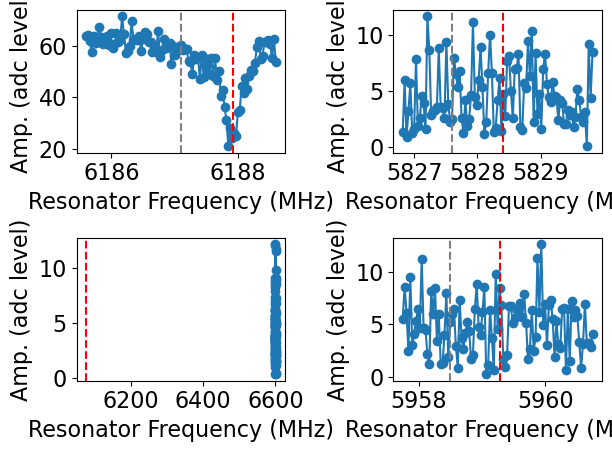

In [94]:
# At gain 0.5*max, 1. 
# 500 reps
plt.subplot(221, xlabel="Resonator Frequency (MHz)", ylabel="Amp. (adc level)")
#plt.plot(f1sweepRF, amps1,'o-',label="amp")
plt.plot(fpts+fcenter[0], amps1,'o-',label="amp")
plt.axvline(6187.1, linestyle='--', color='gray')
plt.axvline(6187.93, linestyle='--', color = 'red')

plt.subplot(222, xlabel="Resonator Frequency (MHz)", ylabel="Amp. (adc level)")
#plt.plot(f2sweepRF, amps2,'o-',label="amp")
plt.plot(fpts+fcenter[1], amps2,'o-',label="amp")
plt.axvline(5827.6, linestyle='--', color='gray')
plt.axvline(5828.4, linestyle='--', color = 'red')

plt.subplot(223, xlabel="Resonator Frequency (MHz)", ylabel="Amp. (adc level)")
#plt.plot(f3sweepRF, amps3,'o-',label="amp")
plt.plot(fpts+fcenter[2], amps3,'o-',label="amp")
#plt.axvline(6074.0, linestyle='--', color='gray')
plt.axvline(6074.54, linestyle='--', color = 'red')


plt.subplot(224, xlabel="Resonator Frequency (MHz)", ylabel="Amp. (adc level)")
#plt.plot(f4sweepRF, amps4,'o-',label="amp")
plt.plot(fpts+fcenter[3], amps4,'o-',label="amp")
plt.axvline(5958.5, linestyle='--', color='gray')
plt.axvline(5959.28, linestyle='--', color = 'red')

plt.tight_layout()

In [730]:
index1 = np.argmin(amps1)
print(fcenter[0] + fpts[index1])

index2 = np.argmin(amps2)
print(fcenter[1] + fpts[index2])

index3 = np.argmin(amps3)
print(fcenter[2] + fpts[index3])

index4 = np.argmin(amps4)
print(fcenter[3] + fpts[index4])

6187.9400000000005
5828.32
6600.6
5959.34


In [223]:
#fpts #difference from center frequency

In [262]:
savepath = '/home/nexusadmin/qick/NEXUS_sandbox/Data'
date = '080524'

saveparams={"res_len": readout_cfg["ro_length"],
           "fcenter": fcenter, #array of 4 center frequencies
           "gains": readout_cfg["mux_gains"],
           "reps": expt_cfg["reps"],
           "rounds": expt_cfg["rounds"]}

np.savez(f"{savepath}/{date}/ResSpec_4_resatten(20,20)", fsweep=fpts, amp1 = amps1, amp2 = amps2, amp3 = amps3, amp4 = amps4, expt_settings = saveparams)


## Spec

In [95]:
class TestSpec(RAveragerProgram):
    def initialize(self):
        # Set up multiplexed readout DAC
        self.declare_gen(ch=self.cfg["res_ch"], nqz=self.cfg["res_nqz"],
                        mux_freqs = self.cfg["res_freqs"],
                        mux_gains = self.cfg["res_gains"])
        
        # Set up 4 qubit pulses
        self.declare_gen(ch=self.cfg["q1_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 1
        self.declare_gen(ch=self.cfg["q2_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 2
        self.declare_gen(ch=self.cfg["q3_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 3
        self.declare_gen(ch=self.cfg["q4_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 4
        
        # Save register page for each qubit
        self.q1_rp=self.ch_page(self.cfg["q1_ch"]) # register page for qubit 1
        self.q2_rp=self.ch_page(self.cfg["q2_ch"]) # register page for qubit 2
        self.q3_rp=self.ch_page(self.cfg["q3_ch"]) # register page for qubit 3
        self.q4_rp=self.ch_page(self.cfg["q4_ch"]) # register page for qubit 4
        

        # Save register gain for each qubit
        self.q1_gain = self.sreg(self.cfg["q1_ch"], "gain")
        self.q2_gain = self.sreg(self.cfg["q2_ch"], "gain")
        self.q3_gain = self.sreg(self.cfg["q3_ch"], "gain")
        self.q4_gain = self.sreg(self.cfg["q4_ch"], "gain")
        
                # Save register freq for each qubit
        self.q1_freq = self.sreg(self.cfg["q1_ch"], "freq")
        self.q2_freq = self.sreg(self.cfg["q2_ch"], "freq")
        self.q3_freq = self.sreg(self.cfg["q3_ch"], "freq")
        self.q4_freq = self.sreg(self.cfg["q4_ch"], "freq")
        
        q1_ge = self.freq2reg(self.cfg["q1_freq"], gen_ch=self.cfg["q1_ch"])
        q2_ge = self.freq2reg(self.cfg["q2_freq"], gen_ch=self.cfg["q2_ch"])
        q3_ge = self.freq2reg(self.cfg["q3_freq"], gen_ch=self.cfg["q3_ch"])
        q4_ge = self.freq2reg(self.cfg["q4_freq"], gen_ch=self.cfg["q4_ch"])
        
        
        self.q1_start = self.freq2reg(self.cfg["q1_start"], gen_ch=self.cfg["q1_ch"])
        self.q2_start = self.freq2reg(self.cfg["q2_start"], gen_ch=self.cfg["q2_ch"])
        self.q3_start = self.freq2reg(self.cfg["q3_start"], gen_ch=self.cfg["q3_ch"])
        self.q4_start = self.freq2reg(self.cfg["q4_start"], gen_ch=self.cfg["q4_ch"])
                                      
            
        self.f_step = self.freq2reg(self.cfg["step"], gen_ch=self.cfg["q1_ch"]) #ok to use arbitrary channel for all steps (sets unit)

        # DAC channel
        res_length = self.us2cycles(self.cfg["res_length"], gen_ch=self.cfg["res_ch"])
        q1_length = self.us2cycles(self.cfg["q1_length"], gen_ch=self.cfg["q1_ch"])
        q2_length = self.us2cycles(self.cfg["q2_length"], gen_ch=self.cfg["q2_ch"])
        q3_length = self.us2cycles(self.cfg["q3_length"], gen_ch=self.cfg["q3_ch"])
        q4_length = self.us2cycles(self.cfg["q4_length"], gen_ch=self.cfg["q4_ch"])
        
        self.set_pulse_registers(ch = self.cfg["res_ch"], style = 'const', length = res_length, mask=[0,1,2,3]) 
        
        self.set_pulse_registers(ch = self.cfg["q1_ch"], style = 'const', freq = self.q1_start, length = q1_length, 
                                 phase=0,
                                 gain = self.cfg['q1_gain'])
        self.set_pulse_registers(ch = self.cfg["q2_ch"], style = 'const', freq = self.q2_start, length = q2_length, 
                                 phase=0,
                                 gain = self.cfg['q2_gain'])#periodic - always pumping
        self.set_pulse_registers(ch = self.cfg["q3_ch"], style = 'const', freq = self.q3_start, length = q3_length, 
                                 phase = 0, gain = self.cfg['q3_gain'])#,mode="periodic")
        self.set_pulse_registers(ch = self.cfg["q4_ch"], style = 'const', freq = self.q4_start, length = q4_length, 
                                  phase = 0, gain = self.cfg['q4_gain'])#,mode="periodic")
#         self.set_pulse_registers(ch = self.cfg["q4_ch"], style = 'const', freq = q4_ge, length = q4_length, 
#                                  phase = 0, gain = self.cfg['q4_gain'])
        
        # Readout
        for i in range(0,4):
            self.declare_readout(ch      = self.cfg['ro_ch'][i],
                                 length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][i]),
                                 freq    = self.cfg['res_freqs'][i],
                                 gen_ch  = self.cfg['res_ch'])
            
        self.synci(200)  # give processor time to configure pulses
        
    def body(self):
        self.pulse(ch = self.cfg["q1_ch"]) # play probe pulse #pulse takes t argument, not given sets to auto (or set t=0)
        self.pulse(ch = self.cfg["q2_ch"]) # play probe pulse
        self.pulse(ch = self.cfg["q3_ch"]) # play probe pulse
        self.pulse(ch = self.cfg["q4_ch"]) # play probe pulse

        self.sync_all()#self.us2cycles(0.05)) # align channels and wait 50ns
        
        # trigger measurement (MUX), play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch        = self.cfg['res_ch'],
                     adcs            = self.ro_chs, #self.cfg["ro_ch"],
                     pins            = [0], # what is this?
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                     syncdelay       = self.us2cycles(self.cfg["relax_delay"]),
                     wait = True
                    )
        
    def update(self):
        self.mathi(self.q1_rp, self.q1_freq, self.q1_freq, '+', self.f_step) # updated frequency list index (?)
        self.mathi(self.q2_rp, self.q2_freq, self.q2_freq, '+', self.f_step)
        self.mathi(self.q3_rp, self.q3_freq, self.q3_freq, '+', self.f_step)
        self.mathi(self.q4_rp, self.q4_freq, self.q4_freq, '+', self.f_step)
        

In [96]:
qcenter = [4909, 4748, 4568, 4761] #[4833, 4704, 4531, 4694]#[4822, 4704, 4531, 4694] #qcenter = [4833, 4708, 4531, 4694] #MHz
mixerfreq = 4100 #MHz

qrange = 10 #MHz #half of total freq sweep range
qstep = 0.5 #MHz
qpts = int((qrange*2)/qstep)+1

readout_cfg={
        "ro_length"   : 3.55, #us
        "ro_offset"   : 0.5, #us

        "res_nqz"     : 2,
        "qubit_nqz"   : 2,
             
        "res_length"  : 3.55, # in us
        "q1_length"   : 20, # in us
        "q2_length"   : 20, #(works with 1 us too)
        "q3_length"   : 20,
        "q4_length"   : 20,
            
        "q1_gain"     : 500, #500, #What is reasonable here? I've seen 10 and ~1000+ in different demos
        "q2_gain"     : 0, #12000, #500, 
        "q3_gain"     : 0, #12000,
        "q4_gain"     : 0, #12000, #500,
        
        "mix_freq"    : mixerfreq, #MHz
             
        "q1_freq"     : qcenter[0] - mixerfreq, 
        "q2_freq"     : qcenter[1] - mixerfreq,
        "q3_freq"     : qcenter[2] - mixerfreq,
        "q4_freq"     : qcenter[3] - mixerfreq,
             
        "q1_start"    : qcenter[0]-qrange - mixerfreq,
        "q2_start"    : qcenter[1]-qrange - mixerfreq,
        "q3_start"    : qcenter[2]-qrange - mixerfreq,
        "q4_start"    : qcenter[3]-qrange - mixerfreq,
             
        "res_gains"  : [0.85,0,0,0],# [0.9,0.45,0.45,0.45] #array of 4 gains - 1 is max output (range 0-1, fraction of max power)
                            #power is split across the 4 tones so they'll have less than in non-MUX pulse
        "res_freqs"  : [6187.85, 5828.38, 6600, 5959.28], #[6187.93,5828.32,6074.6,5959.28], #[6187.93,5828.32,6074.46,5959.28], #array of 4 pulse freq
       }


In [97]:
expt_cfg={"reps":10, "rounds": 500, "relax_delay":20, 
          "start": -qrange, "step":qstep, "expts":qpts,
         }
config={**readout_cfg,**expt_cfg, **ch_config} #combine configs

# fpts=expt_cfg["start"] + expt_cfg["step"]*np.arange(expt_cfg["expts"])

q1_fpts=readout_cfg["q1_start"] + expt_cfg["step"]*np.arange(expt_cfg["expts"])
q2_fpts=readout_cfg["q2_start"] + expt_cfg["step"]*np.arange(expt_cfg["expts"])
q3_fpts=readout_cfg["q3_start"] + expt_cfg["step"]*np.arange(expt_cfg["expts"])
q4_fpts=readout_cfg["q4_start"] + expt_cfg["step"]*np.arange(expt_cfg["expts"])
print(config)

{'ro_length': 3.55, 'ro_offset': 0.5, 'res_nqz': 2, 'qubit_nqz': 2, 'res_length': 3.55, 'q1_length': 20, 'q2_length': 20, 'q3_length': 20, 'q4_length': 20, 'q1_gain': 500, 'q2_gain': 0, 'q3_gain': 0, 'q4_gain': 0, 'mix_freq': 4100, 'q1_freq': 809, 'q2_freq': 648, 'q3_freq': 468, 'q4_freq': 661, 'q1_start': 799, 'q2_start': 638, 'q3_start': 458, 'q4_start': 651, 'res_gains': [0.85, 0, 0, 0], 'res_freqs': [6187.85, 5828.38, 6600, 5959.28], 'reps': 10, 'rounds': 500, 'relax_delay': 20, 'start': -10, 'step': 0.5, 'expts': 41, 'res_ch': 15, 'q1_ch': 4, 'q2_ch': 5, 'q3_ch': 6, 'q4_ch': 7, 'ro_ch': [0, 1, 2, 3]}


In [98]:
qspec=TestSpec(soccfg, config)
expt_pts, avgi, avgq = qspec.acquire(soc, load_pulses=True, progress=True)
amp1 = np.abs(avgi[0][0]+1j*avgq[0][0])
amp2 = np.abs(avgi[1][0]+1j*avgq[1][0])
amp3 = np.abs(avgi[2][0]+1j*avgq[2][0])
amp4 = np.abs(avgi[3][0]+1j*avgq[3][0])

soc.reset_gens() #turns off periodic output on any generator
 

  0%|          | 0/500 [00:00<?, ?it/s]

In [99]:
amp1 = np.abs(avgi[0][0]+1j*avgq[0][0])
amp2 = np.abs(avgi[1][0]+1j*avgq[1][0])
amp3 = np.abs(avgi[2][0]+1j*avgq[2][0])
amp4 = np.abs(avgi[3][0]+1j*avgq[3][0])

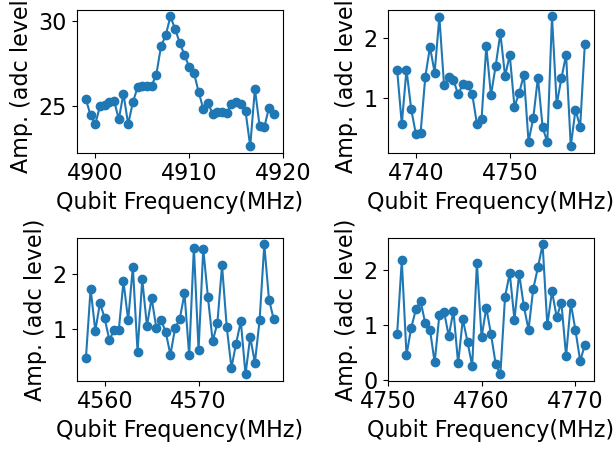

In [100]:
plt.subplot(221, xlabel="Qubit Frequency(MHz)", ylabel="Amp. (adc level)")
plt.plot(q1_fpts + mixerfreq, amp1, 'o-')
#plt.axvline(4833.0, color="red") #old value

plt.subplot(222, xlabel="Qubit Frequency(MHz)", ylabel="Amp. (adc level)")
plt.plot(q2_fpts + mixerfreq, amp2, 'o-')
# plt.plot(q2_fpts + mixerfreq, i2, 'o-')
# plt.plot(q2_fpts + mixerfreq, q2, 'o-')
# plt.axvline(4711, color="red")

plt.subplot(223, xlabel="Qubit Frequency(MHz)", ylabel="Amp. (adc level)")
plt.plot(q3_fpts + mixerfreq, amp3, 'o-')

plt.subplot(224, xlabel="Qubit Frequency(MHz)", ylabel="Amp. (adc level)")
plt.plot(q4_fpts + mixerfreq, amp4, 'o-')

plt.tight_layout()

In [101]:
print(q1_fpts[np.argmax(amp1)]+ mixerfreq)

4908.0


In [289]:
savepath = '/home/nexusadmin/qick/NEXUS_sandbox/Data'
date = '080524'

saveparams={"res_len": readout_cfg["ro_length"],
           "q_len": readout_cfg["q2_length"],
           "res_freq": readout_cfg["res_freqs"], #array of 4 center frequencies
           "qcenter": qcenter, #array of 4 center frequencies,
            "mixer_freq": mixerfreq,
            "q_gain": readout_cfg["q2_gain"],
           "res_gains": readout_cfg["res_gains"],
           "reps": expt_cfg["reps"],
           "rounds": expt_cfg["rounds"]}

np.savez(f"{savepath}/{date}/QubitSpec_4_resAtten(20,20)_qAtten(5,5)", fsweep=q2_fpts, amp1 = amps1, amp2 = amps2, amp3 = amps3, amp4 = amps4, expt_settings = saveparams)

## Rabi

In [846]:
class TestRabi(RAveragerProgram):
    def initialize(self):
        cfg = self.cfg
        # Set up multiplexed readout DAC
        self.declare_gen(ch=self.cfg["res_ch"], nqz=self.cfg["res_nqz"],
                        mux_freqs = self.cfg["res_freqs"],
                        mux_gains = self.cfg["res_gains"])
        
        # Set up 4 qubit pulses
#         self.declare_gen(ch=self.cfg["qubit_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 4
        self.declare_gen(ch=self.cfg["q1_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 1
        self.declare_gen(ch=self.cfg["q2_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 2
        self.declare_gen(ch=self.cfg["q3_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 3
        self.declare_gen(ch=self.cfg["q4_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 4
        
        
        # Save register page for each qubit
#         self.q_rp=self.ch_page(self.cfg["qubit_ch"]) # register page for qubit 4
        self.q1_rp=self.ch_page(self.cfg["q1_ch"]) # register page for qubit 1
        self.q2_rp=self.ch_page(self.cfg["q2_ch"]) # register page for qubit 2
        self.q3_rp=self.ch_page(self.cfg["q3_ch"]) # register page for qubit 3
        self.q4_rp=self.ch_page(self.cfg["q4_ch"]) # register page for qubit 4

        # Save register gain for each qubit
#         self.q_gain = self.sreg(self.cfg["qubit_ch"], "addr")
        self.q1_gain = self.sreg(self.cfg["q1_ch"], "addr")
        self.q2_gain = self.sreg(self.cfg["q2_ch"], "addr")
        self.q3_gain = self.sreg(self.cfg["q3_ch"], "addr")
        self.q4_gain = self.sreg(self.cfg["q4_ch"], "addr")

#         self.q_ge = self.freq2reg(self.cfg["qubit_freq"], gen_ch=self.cfg["qubit_ch"])
        q1_ge = self.freq2reg(self.cfg["q1_freq"], gen_ch=self.cfg["q1_ch"])
        q2_ge = self.freq2reg(self.cfg["q2_freq"], gen_ch=self.cfg["q2_ch"])
        q3_ge = self.freq2reg(self.cfg["q3_freq"], gen_ch=self.cfg["q3_ch"])
        q4_ge = self.freq2reg(self.cfg["q4_freq"], gen_ch=self.cfg["q4_ch"])

        # DAC channel
        res_length = self.us2cycles(self.cfg["res_length"], gen_ch=self.cfg["res_ch"])

        self.set_pulse_registers(ch = self.cfg["res_ch"], style = 'const', length = res_length, mask=[0,1,2,3]) 

#         self.add_gauss(ch=self.cfg["qubit_ch"], name="qubit", sigma=self.cfg["sigma"], 
#                        length=self.cfg["sigma"]*4)
        #Guassian qubit pulses
        self.add_gauss(ch=cfg["q1_ch"], name="qubit1", sigma=cfg["q1_sigma"], length=cfg["q1_sigma"]*4)
        self.add_gauss(ch=cfg["q2_ch"], name="qubit2", sigma=cfg["q2_sigma"], length=cfg["q2_sigma"]*4)
        self.add_gauss(ch=cfg["q3_ch"], name="qubit3", sigma=cfg["q3_sigma"], length=cfg["q3_sigma"]*4)
        self.add_gauss(ch=cfg["q4_ch"], name="qubit4", sigma=cfg["q4_sigma"], length=cfg["q4_sigma"]*4)

#         self.set_pulse_registers(ch = self.cfg["qubit_ch"], style = 'arb', freq = self.q_ge, 
#                                  phase = self.deg2reg(90, gen_ch=self.cfg["qubit_ch"]),
#                                  gain = self.cfg['start'], waveform="qubit")
        
        self.set_pulse_registers(ch = self.cfg["q1_ch"], style = 'arb', freq = q1_ge, 
                                 phase = self.deg2reg(90, gen_ch=cfg["q1_ch"]),
                                gain = self.cfg['start'], waveform="qubit1")
        self.set_pulse_registers(ch = self.cfg["q2_ch"], style = 'arb', freq = q2_ge, 
                                 phase = self.deg2reg(90, gen_ch=cfg["q2_ch"]),
                                 gain = self.cfg['start'], waveform="qubit2")
        self.set_pulse_registers(ch = self.cfg["q3_ch"], style = 'arb', freq = q3_ge, 
                                 phase = self.deg2reg(90, gen_ch=cfg["q3_ch"]),
                                 gain = self.cfg['start'], waveform="qubit3")
        self.set_pulse_registers(ch = self.cfg["q4_ch"], style = 'arb', freq = q4_ge, 
                                 phase = self.deg2reg(90, gen_ch=cfg["q4_ch"]),
                                 gain = self.cfg['start'], waveform="qubit4")

        # Readout
        for i in range(0,4):
            self.declare_readout(ch      = self.cfg['ro_ch'][i],
                                 length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][i]),
                                 freq    = self.cfg['res_freqs'][i],
                                 gen_ch  = self.cfg['res_ch'])
            
        self.synci(200)  # give processor time to configure pulses
        
    def body(self):
        self.pulse(ch = self.cfg["q1_ch"]) # play probe pulse #pulse takes t argument, not given sets to auto (or set t=0)
        self.pulse(ch = self.cfg["q2_ch"]) # play probe pulse
#         self.pulse(ch = self.cfg["q3_ch"]) # play probe pulse
        self.pulse(ch = self.cfg["q4_ch"]) # play probe pulse
        
        self.sync_all()#self.us2cycles(0.05)) # align channels and wait 50ns
        
        # trigger measurement (MUX), play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch        = self.cfg['res_ch'],
                     adcs            = self.ro_chs, #self.cfg["ro_ch"],
                     pins            = [0], # what is this?
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                     syncdelay       = self.us2cycles(self.cfg["relax_delay"]),
                     wait = True
                    )
        
    def update(self):
        self.mathi(self.q1_rp, self.q1_gain, self.q1_gain, '+', self.cfg["step"]<<16) # update gain of the Gaussian pi pulse
        self.mathi(self.q2_rp, self.q2_gain, self.q2_gain, '+', self.cfg["step"]<<16) # update gain of the Gaussian pi pulse
        self.mathi(self.q3_rp, self.q3_gain, self.q3_gain, '+', self.cfg["step"]<<16) # update gain of the Gaussian pi pulse
        self.mathi(self.q4_rp, self.q4_gain, self.q4_gain, '+', self.cfg["step"]<<16) # update gain of the Gaussian pi pulse
    
    

In [847]:
qcenter = [4909, 4749, 4569, 4759] #[4833, 4704, 4531, 4694]#[4822, 4704, 4531, 4694] #qcenter = [4833, 4708, 4531, 4694] #MHz
mixerfreq = 4100 #MHz

readout_cfg={
        "ro_length"   : L3, #3.55, #us
        "ro_offset"   : 0.5, #us
        "res_length"  : L3, #3.55, # in us

        "res_nqz"     : 2,
        "qubit_nqz"   : 2,
                     
        "mix_freq"    : mixerfreq, #MHz
             
        "res_gains"  : [1,1,0,1],# [0.9,0.45,0.45,0.45] #array of 4 gains - 1 is max output (range 0-1, fraction of max power)
                            #power is split across the 4 tones so they'll have less than in non-MUX pulse
        "res_freqs"  : [6187.93, 5828.32, 6600, 5959.28], #[6187.93,5828.32,6600,5959.28], #[6187.93,5828.32,6074.46,5959.28], #array of 4 pulse freq
       }

soc.rfb_set_gen_rf(ch_config['q1_ch'], 2,5) # spec params are 20,15 for all 4 qubits
soc.rfb_set_gen_rf(ch_config['q2_ch'], 2,5) #(5,5)
soc.rfb_set_gen_rf(ch_config['q3_ch'], 2,5)
soc.rfb_set_gen_rf(ch_config['q4_ch'], 2,5) #(5,5)


In [848]:
expt_cfg={"reps":1500, "rounds": 5, "relax_delay":100, 
          "start": 0, "step": 1000, "expts": 30,
          "q1_sigma"    : soc.us2cycles(0.02, gen_ch=ch_config["q1_ch"]),
          "q2_sigma"    : soc.us2cycles(0.02, gen_ch=ch_config["q2_ch"]),
          "q3_sigma"    : soc.us2cycles(0.02, gen_ch=ch_config["q3_ch"]),
          "q4_sigma"    : soc.us2cycles(0.02, gen_ch=ch_config["q4_ch"]),
          "q1_ch" : ch_config["q1_ch"],
          "q2_ch" : ch_config["q2_ch"],
          "q3_ch" : ch_config["q3_ch"],
          "q4_ch" : ch_config["q4_ch"],
          "q1_freq" : qcenter[0] - mixerfreq, #qcenter[0] - mixerfreq,
          "q2_freq" : qcenter[1] - mixerfreq,
          "q3_freq" : qcenter[2] - mixerfreq,
          "q4_freq" : qcenter[3] - mixerfreq,
         }

config={**readout_cfg,**expt_cfg, **ch_config} #combine configs

print(config)

{'ro_length': 12.5, 'ro_offset': 0.5, 'res_length': 12.5, 'res_nqz': 2, 'qubit_nqz': 2, 'mix_freq': 4100, 'res_gains': [1, 1, 0, 1], 'res_freqs': [6187.93, 5828.32, 6600, 5959.28], 'reps': 1500, 'rounds': 5, 'relax_delay': 100, 'start': 0, 'step': 1000, 'expts': 30, 'q1_sigma': 9, 'q2_sigma': 9, 'q3_sigma': 9, 'q4_sigma': 9, 'q1_ch': 4, 'q2_ch': 5, 'q3_ch': 6, 'q4_ch': 7, 'q1_freq': 809, 'q2_freq': 649, 'q3_freq': 469, 'q4_freq': 659, 'res_ch': 15, 'ro_ch': [0, 1, 2, 3]}


In [849]:
qspec=TestRabi(soccfg, config)
# print(qspec)
expt_pts, avgi, avgq = qspec.acquire(soc, load_pulses=True, progress=True)
amp1 = np.abs(avgi[0][0]+1j*avgq[0][0])
amp2 = np.abs(avgi[1][0]+1j*avgq[1][0])
amp3 = np.abs(avgi[2][0]+1j*avgq[2][0])
amp4 = np.abs(avgi[3][0]+1j*avgq[3][0])

soc.reset_gens() #turns off periodic output on any generator
 

  0%|          | 0/5 [00:00<?, ?it/s]

In [850]:
def cosine(x, a, b, c, d):
    return a * np.cos(2. * np.pi * b * x - c * 2 * np.pi) + d

q1_amp = amp1
q1_a_guess = (np.max(q1_amp) - np.min(q1_amp)) / 2
q1_b_guess = 1/expt_pts[-1]
q1_c_guess = 0
q1_d_guess = np.mean(q1_amp)

q1_guess=[q1_a_guess, q1_b_guess, q1_c_guess, q1_d_guess]
q1_popt, q1_pcov = curve_fit(cosine, expt_pts, q1_amp, maxfev = 100000, p0 = q1_guess)
q1_fit_cosine = cosine(expt_pts, *q1_popt)

q2_amp = amp2
q2_a_guess = (np.max(q2_amp) - np.min(q2_amp)) / 2
q2_b_guess = 1/expt_pts[-1]
q2_c_guess = 0
q2_d_guess = np.mean(q2_amp)

q2_guess=[q2_a_guess, q2_b_guess, q2_c_guess, q2_d_guess]
q2_popt, q2_pcov = curve_fit(cosine, expt_pts, q2_amp, maxfev = 100000, p0 = q2_guess)
q2_fit_cosine = cosine(expt_pts, *q2_popt)

q3_amp = amp3
q3_a_guess = (np.max(q3_amp) - np.min(q3_amp)) / 2
q3_b_guess = 1/expt_pts[-1]
q3_c_guess = 0
q3_d_guess = np.mean(q3_amp)

q3_guess=[q3_a_guess, q3_b_guess, q3_c_guess, q3_d_guess]
q3_popt, q3_pcov = curve_fit(cosine, expt_pts, q3_amp, maxfev = 100000, p0 = q3_guess)
q3_fit_cosine = cosine(expt_pts, *q3_popt)

q4_amp = amp4
q4_a_guess = (np.max(q4_amp) - np.min(q4_amp)) / 2
q4_b_guess = 1/expt_pts[-1]
q4_c_guess = 0
q4_d_guess = np.mean(q4_amp)

q4_guess=[q4_a_guess, q4_b_guess, q4_c_guess, q4_d_guess]
q4_popt, q4_pcov = curve_fit(cosine, expt_pts, q4_amp, maxfev = 100000, p0 = q4_guess)
q4_fit_cosine = cosine(expt_pts, *q4_popt)

In [851]:
q1_pi_amp = expt_pts[np.argmax(q1_fit_cosine)]
print(int(q1_pi_amp))

q2_pi_amp = expt_pts[np.argmax(q2_fit_cosine)]
print(int(q2_pi_amp))

q3_pi_amp = expt_pts[np.argmax(q3_fit_cosine)]
print(int(q3_pi_amp))

q4_pi_amp = expt_pts[np.argmax(q4_fit_cosine)]
print(int(q4_pi_amp))

27000
23000
9000
25000


In [852]:

print(np.where(q1_fit_cosine == (np.max(q1_fit_cosine) + np.min(q1_fit_cosine))/2))

(array([], dtype=int64),)


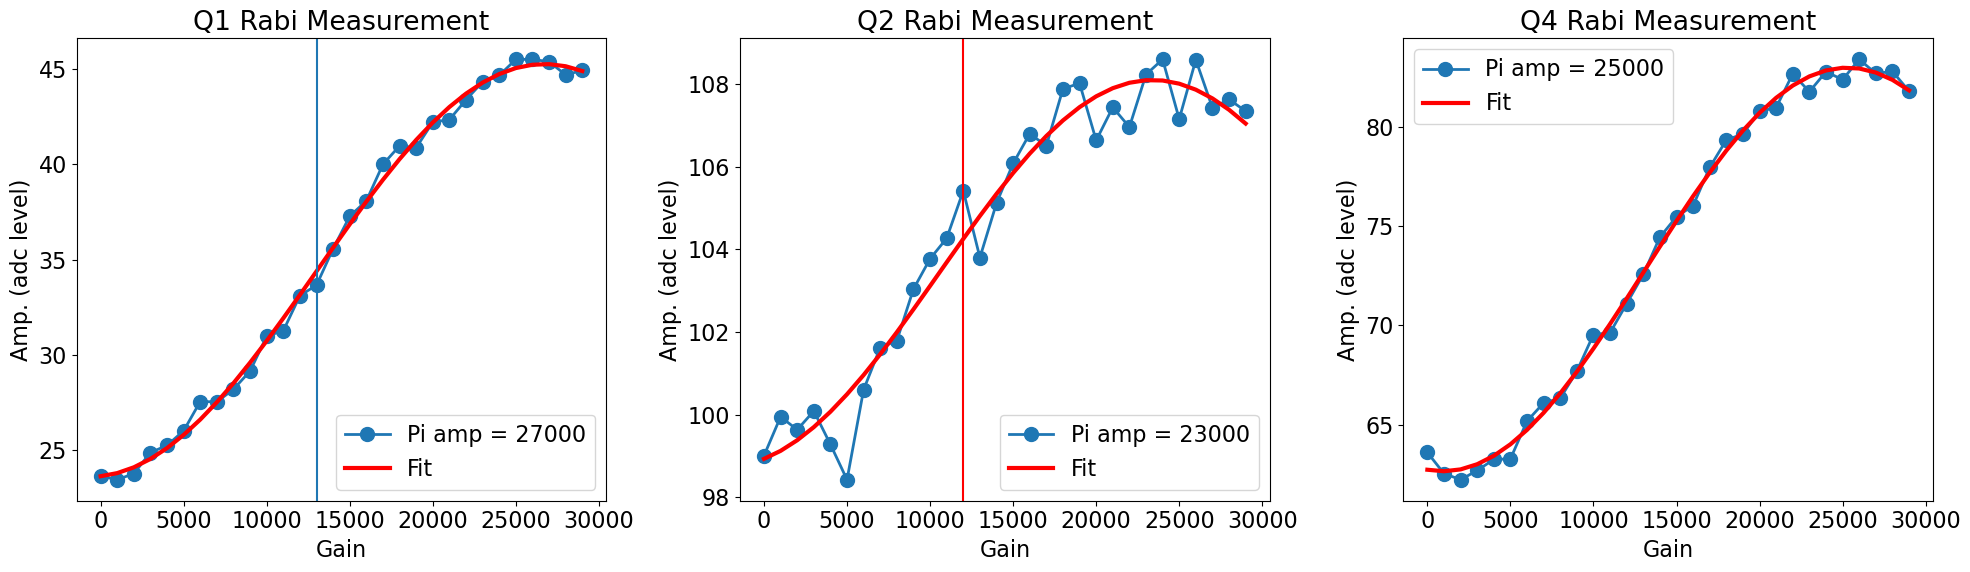

In [853]:
# Set up the figure 
plt.figure(figsize=(20, 6))
# Increase the font size
plt.rcParams.update({'font.size': 16})

# Create subplots
plt.subplot(131)
plt.plot(expt_pts, amp1, 'o-', linewidth=2, markersize=10, label=f"Pi amp = {q1_pi_amp:d}")
plt.plot(expt_pts, q1_fit_cosine, '-', color='red', linewidth=3, label="Fit")
# plt.axhline((np.max(q1_fit_cosine) + np.min(q1_fit_cosine))/2, color='black')
plt.axvline(13000)
plt.xlabel("Gain")
plt.ylabel("Amp. (adc level)")
plt.legend()
plt.title("Q1 Rabi Measurement")

plt.subplot(132)
plt.plot(expt_pts, amp2, 'o-', linewidth=2, markersize=10, label=f"Pi amp = {q2_pi_amp:d}")
plt.plot(expt_pts, q2_fit_cosine, '-', color='red', linewidth=3, label="Fit")
plt.axvline(12000, color = 'red')
plt.xlabel("Gain")
plt.ylabel("Amp. (adc level)")
plt.legend()
plt.title("Q2 Rabi Measurement")

# plt.subplot(132)
# plt.plot(expt_pts, amp3, 'o-', linewidth=2, markersize=10,  label=f"Pi amp = {q3_pi_amp:d}")
# plt.plot(expt_pts, q3_fit_cosine, '-', color='red', linewidth=3, label="Fit")
# plt.xlabel("Gain")
# plt.ylabel("Amp. (adc level)")
# plt.legend()
# plt.title("Q3 Rabi Measurement")

plt.subplot(133)
plt.plot(expt_pts, amp4, 'o-', linewidth=2, markersize=10, label=f"Pi amp = {q4_pi_amp:d}")
plt.plot(expt_pts, q4_fit_cosine, '-', color='red', linewidth=3, label="Fit")
plt.xlabel("Gain")
plt.ylabel("Amp. (adc level)")
plt.legend()
plt.title("Q4 Rabi Measurement")


# Adjust layout and display
plt.tight_layout()
plt.show()

In [854]:
# Just looking at these by eye for now
q1_pi2_amp = 15000
q2_pi2_amp = 11000
q3_pi2_amp = 75000 # dummy value
q4_pi2_amp = 15000

In [636]:

savepath = '/home/nexusadmin/qick/NEXUS_sandbox/Data'
date = '080624'

saveparams={"res_len": readout_cfg["ro_length"],
            "sigma": expt_cfg["q1_sigma"],
           "res_freq": readout_cfg["res_freqs"], #array of 4 center frequencies
            "qcenter": qcenter,
           "res_gains": readout_cfg["res_gains"],
           "reps": expt_cfg["reps"],
           "rounds": expt_cfg["rounds"]}

np.savez(f"{savepath}/{date}/QubitRabi_234_resAtten(8,30)_qAtten(2,5)", gain_sweep = expt_pts, amp1 = amps1, amp2 = amps2, amp3 = amps3, amp4 = amps4, expt_settings = saveparams)


## Single shot readout fidelity for qubit 2

In [504]:
class SingleShotProgram(RAveragerProgram):
    def initialize(self):
        
        self.cfg["start"]=0
        self.cfg["step"]=self.cfg["pi_gain"]
        self.cfg["reps"]=self.cfg["shots"]
        self.cfg["expts"]=2
        
        # Set up multiplexed readout DAC
        self.declare_gen(ch=self.cfg["res_ch"], nqz=self.cfg["res_nqz"],
                        mux_freqs = self.cfg["res_freqs"],
                        mux_gains = self.cfg["res_gains"])
        
        # Set up 4 qubit pulses
        self.declare_gen(ch=self.cfg["qubit_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 4

        # Save register page for each qubit
        self.q_rp=self.ch_page(self.cfg["qubit_ch"]) # register page for qubit 3

        # Save register gain for each qubit
        self.q_gain = self.sreg(self.cfg["qubit_ch"], "addr")

        self.q_ge = self.freq2reg(self.cfg["qubit_freq"], gen_ch=self.cfg["qubit_ch"])

        # DAC channel
        res_length = self.us2cycles(self.cfg["res_length"], gen_ch=self.cfg["res_ch"])

        self.set_pulse_registers(ch = self.cfg["res_ch"], style = 'const', length = res_length, mask=[0,1,2,3]) 

        self.add_gauss(ch=self.cfg["qubit_ch"], name="qubit", sigma=self.cfg["sigma"], 
                       length=self.cfg["sigma"]*4)
        self.set_pulse_registers(ch = self.cfg["qubit_ch"], style = 'arb', freq = self.q_ge, 
                                 phase = self.deg2reg(90, gen_ch=self.cfg["qubit_ch"]),
                                 gain = self.cfg['start'], waveform="qubit")

        # Readout
        for i in range(0,4):
            self.declare_readout(ch      = self.cfg['ro_ch'][i],
                                 length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][i]),
                                 freq    = self.cfg['res_freqs'][i],
                                 gen_ch  = self.cfg['res_ch'])
            
        self.synci(200)  # give processor time to configure pulses
        
    def body(self):
        self.pulse(ch = self.cfg["qubit_ch"]) # play probe pulse
        self.sync_all()#self.us2cycles(0.05)) # align channels and wait 50ns
        
        # trigger measurement (MUX), play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch        = self.cfg['res_ch'],
                     adcs            = self.ro_chs, #self.cfg["ro_ch"],
                     pins            = [0], # what is this?
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                     syncdelay       = self.us2cycles(self.cfg["relax_delay"]),
                     wait = True
                    )
        
    def update(self):
        self.mathi(self.q_rp, self.q_gain, self.q_gain, '+', self.cfg["step"]<<16) # update gain of the Gaussian pi pulse
     
    def acquire(self,soc, progress=False):
        super().acquire(soc, progress=progress)
        return self.collect_shots()
       
    def collect_shots(self):
        shots_i0=self.di_buf[self.cfg["res_index"]].reshape((self.cfg["expts"],self.cfg["reps"]))/self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][0])
        shots_q0=self.dq_buf[self.cfg["res_index"]].reshape((self.cfg["expts"],self.cfg["reps"]))/self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][0])
        return shots_i0,shots_q0
        

    def analyze(self, shots_i, shots_q):
        plt.subplot(111, xlabel='I', ylabel='Q', title='Single Shot Histogram')
        plt.plot(shots_i[0],shots_q[0],'.',label='g')
        plt.plot(shots_i[1],shots_q[1],'.',label='e')
        plt.legend()
        plt.gca().set_aspect('equal', 'datalim')

In [558]:
qcenter = [4909, 4749.4, 4569, 4759] #[4833, 4704, 4531, 4694]#[4822, 4704, 4531, 4694] #qcenter = [4833, 4708, 4531, 4694] #MHz
mixerfreq = 4100 #MHz
readout_length = 10.5
readout_cfg={
        "ro_length"   : readout_length, #us
        "ro_offset"   : 0.5, #us
        "res_length"  : readout_length, # in us

        "res_nqz"     : 2,
        "qubit_nqz"   : 2,
                     
        "mix_freq"    : mixerfreq, #MHz
            
        "res_gains"  : [0,0,0,G3],# [0.9,0.45,0.45,0.45] #array of 4 gains - 1 is max output (range 0-1, fraction of max power)
                            #power is split across the 4 tones so they'll have less than in non-MUX pulse
        "res_freqs"  : [6187.93, 5828.38, 6600, 5959.31], #[6187.93,5828.32,6600,5959.28], #[6187.93,5828.32,6074.46,5959.28], #array of 4 pulse freq
       }



In [506]:
ssf_expt_cfg={"shots": 3000, "relax_delay":500, "sigma":soc.us2cycles(0.04, gen_ch=ch_config["q4_ch"]),
          "qubit_ch":ch_config["q4_ch"], "pi_gain":q4_pi_amp,
          "qubit_freq" : qcenter[3] - mixerfreq,
          "res_index" : 0
         }


config={**readout_cfg,**ssf_expt_cfg, **ch_config} #combine configs

print(config)

{'ro_length': 10.5, 'ro_offset': 0.5, 'res_length': 10.5, 'res_nqz': 2, 'qubit_nqz': 2, 'mix_freq': 4100, 'res_gains': [0, 0, 0, 1], 'res_freqs': [6600, 5828.38, 6074.6, 5959.31], 'shots': 3000, 'relax_delay': 500, 'sigma': 17, 'qubit_ch': 7, 'pi_gain': 22000, 'qubit_freq': 659, 'res_index': 0, 'res_ch': 15, 'q1_ch': 4, 'q2_ch': 5, 'q3_ch': 6, 'q4_ch': 7, 'ro_ch': [0, 1, 2, 3]}


In [507]:
ssp=SingleShotProgram(soccfg, config)

di0, dq0 = ssp.acquire(soc,progress=True)

  0%|          | 0/6000 [00:00<?, ?it/s]

In [508]:
fid, threshold, angle = hist_ssf(data=[di0[0], dq0[0], di0[1], dq0[1]],  plot=False, ran=1000)
print('Optimal fidelity after rotation = %.3f' % fid)
# readout_cfg["res_phase"]=soccfg.deg2reg(-angle*180/pi, gen_ch=5)
# readout_cfg["threshold"]=round(threshold)
print(fid)

Optimal fidelity after rotation = 0.021
0.021


In [457]:
savepath = '/home/nexusadmin/qick/NEXUS_sandbox/Data'
date = '080524'

saveparams={"res_len": readout_cfg["ro_length"],
           "res_freq": readout_cfg["res_freqs"], #array of 4 center frequencies
            "qcenter": qcenter,
           "res_gains": readout_cfg["res_gains"],
           "shots": ssf_expt_cfg["shots"],
           "q_sigma": ssf_expt_cfg["sigma"],
           "q_gain":ssf_expt_cfg["pi_gain"]}


np.savez(f"{savepath}/{date}/SSF_1_resAtten(20,20)_qAtten(5,5)", Idata=di0, Qdata=dq0, expt_settings = saveparams)


In [718]:
fcenter[0]

6187.1

## SSF Sweep

In [305]:
L1 = 12 #us
L2 = 11.5
L3 = 12.5 #us

config["ro_length"] = L3
config["res_length"] = L3

F1 = 6187.55 # MHz
F2 = 6187.75
F3 = 6187.65 # MHz

G1 = 0.95
G2 = 1
G3 = 1

config["res_freqs"] = [F2, 5828.3, 6600, 5959.3]
config["res_gains"] = [G3, 0,0,0]

A1 = 30 #16.5
soc.rfb_set_ro_rf(ch_config['ro_ch'][0], A1)

soc.rfb_set_gen_rf(ch_config['res_ch'], 8, 30)

In [86]:
ro_len_start = 9 #us
ro_len_stop = 14.5 #us
ro_len_step = 0.5 #us

ro_sweep = np.arange(ro_len_start, ro_len_stop, ro_len_step)
ro_len_pts = len(ro_sweep)

# resg_start = 0.5
# resg_stop = 1
# resg_pts = 10
# resg_sweep = np.linspace(resg_start, resg_stop, resg_pts, endpoint=True)

res_freq = 6187.7 #fcenter[0]
freq_span = 0.5
fstart = res_freq - freq_span/2
fstop = res_freq + freq_span/2
freq_pts = 5

fsweep = np.linspace(fstart, fstop, freq_pts, endpoint=True)

fids = np.zeros((ro_len_pts, freq_pts))

# atten_start = 22
# atten_stop = 13
# atten_step = 0.5

# atten_sweep = np.arange(atten_stop, atten_start, atten_step)

#fids = np.zeros(ro_len_pts)

for n,l in enumerate(tqdm(ro_sweep)):
    config["ro_length"] = l
    config["res_length"] = l
    #config["res_gains"] = [g, 0,0,0]
    #soc.rfb_set_ro_rf(ch_config['ro_ch'][0], a)
    
#     ssp = SingleShotProgram(soccfg,config)
#     di0, dq0 = ssp.acquire(soc,progress=True)
#     fid, threshold, angle = hist_ssf(data=[di0[0], dq0[0], di0[1], dq0[1]],  plot=False, ran=1000)
#     fids[n] = fid
    
    for m, f in enumerate(tqdm(fsweep)):
        config["res_freqs"] = [f, 5828.3, 6600, 5959.3]
        
        ssp = SingleShotProgram(soccfg, config)
        di0, dq0 = ssp.acquire(soc,progress=True)
        
        fid, threshold, angle = hist_ssf(data=[di0[0], dq0[0], di0[1], dq0[1]],  plot=False, ran=1000)
        
        fids[n][m] = fid


  0%|                                                     | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


 20%|█████████                                    | 1/5 [00:03<00:12,  3.09s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 40%|██████████████████                           | 2/5 [00:06<00:09,  3.11s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 60%|███████████████████████████                  | 3/5 [00:09<00:06,  3.11s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 80%|████████████████████████████████████         | 4/5 [00:12<00:03,  3.11s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


  0%|                                                     | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


 20%|█████████                                    | 1/5 [00:03<00:12,  3.13s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 40%|██████████████████                           | 2/5 [00:06<00:09,  3.13s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 60%|███████████████████████████                  | 3/5 [00:09<00:06,  3.13s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 80%|████████████████████████████████████         | 4/5 [00:12<00:03,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


  0%|                                                     | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


 20%|█████████                                    | 1/5 [00:03<00:12,  3.13s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 40%|██████████████████                           | 2/5 [00:06<00:09,  3.11s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 60%|███████████████████████████                  | 3/5 [00:09<00:06,  3.11s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 80%|████████████████████████████████████         | 4/5 [00:12<00:03,  3.11s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


  0%|                                                     | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


 20%|█████████                                    | 1/5 [00:03<00:12,  3.11s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 40%|██████████████████                           | 2/5 [00:06<00:09,  3.11s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 60%|███████████████████████████                  | 3/5 [00:09<00:06,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 80%|████████████████████████████████████         | 4/5 [00:12<00:03,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


  0%|                                                     | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


 20%|█████████                                    | 1/5 [00:03<00:12,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 40%|██████████████████                           | 2/5 [00:06<00:09,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 60%|███████████████████████████                  | 3/5 [00:09<00:06,  3.21s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 80%|████████████████████████████████████         | 4/5 [00:12<00:03,  3.18s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


  0%|                                                     | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


 20%|█████████                                    | 1/5 [00:03<00:12,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 40%|██████████████████                           | 2/5 [00:06<00:09,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 60%|███████████████████████████                  | 3/5 [00:09<00:06,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 80%|████████████████████████████████████         | 4/5 [00:12<00:03,  3.13s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


  0%|                                                     | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


 20%|█████████                                    | 1/5 [00:03<00:12,  3.11s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 40%|██████████████████                           | 2/5 [00:06<00:09,  3.13s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 60%|███████████████████████████                  | 3/5 [00:09<00:06,  3.13s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 80%|████████████████████████████████████         | 4/5 [00:12<00:03,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


  0%|                                                     | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


 20%|█████████                                    | 1/5 [00:03<00:12,  3.15s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 40%|██████████████████                           | 2/5 [00:06<00:09,  3.15s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 60%|███████████████████████████                  | 3/5 [00:09<00:06,  3.13s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 80%|████████████████████████████████████         | 4/5 [00:12<00:03,  3.14s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


  0%|                                                     | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


 20%|█████████                                    | 1/5 [00:03<00:12,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 40%|██████████████████                           | 2/5 [00:06<00:09,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 60%|███████████████████████████                  | 3/5 [00:09<00:06,  3.13s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 80%|████████████████████████████████████         | 4/5 [00:12<00:03,  3.13s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


  0%|                                                     | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


 20%|█████████                                    | 1/5 [00:03<00:12,  3.13s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 40%|██████████████████                           | 2/5 [00:06<00:09,  3.13s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 60%|███████████████████████████                  | 3/5 [00:09<00:06,  3.13s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 80%|████████████████████████████████████         | 4/5 [00:12<00:03,  3.15s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


  0%|                                                     | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


 20%|█████████                                    | 1/5 [00:03<00:12,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 40%|██████████████████                           | 2/5 [00:06<00:09,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 60%|███████████████████████████                  | 3/5 [00:09<00:06,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


 80%|████████████████████████████████████         | 4/5 [00:12<00:03,  3.12s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]


100%|███████████████████████████████████████████| 11/11 [02:52<00:00, 15.65s/it]


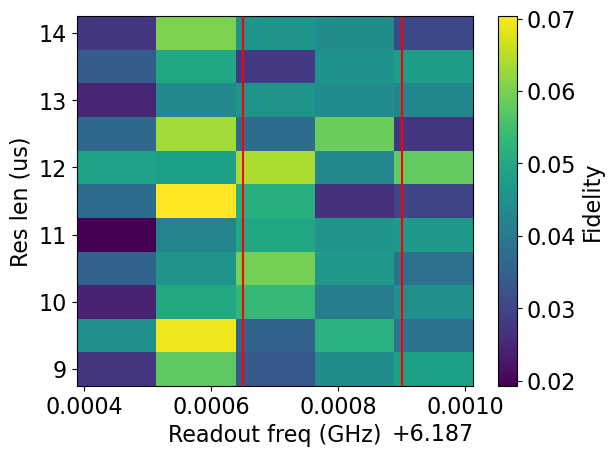

In [88]:
fstep = fsweep[1]-fsweep[0]
#resg_step = resg_sweep[1] - resg_sweep[0]
bounds = [(min(fsweep)-fstep/2)*10**-3, (max(fsweep)+fstep/2)*10**-3, min(ro_sweep)-ro_len_step/2, max(ro_sweep)+ro_len_step/2]
#bounds = [(min(fsweep)-fstep/2)*10**-3, (max(fsweep)+fstep/2)*10**-3, min(resg_sweep)-resg_step/2, max(resg_sweep)+resg_step/2]


plt.subplot(111, xlabel = "Readout freq (GHz)", ylabel = "Res len (us)")
im = plt.imshow(fids, origin='lower', extent=bounds, aspect='auto')
colorbar(im, label="Fidelity")
plt.axvline(6187.65*10**-3, color='red')
plt.axvline(6187.9*10**-3, color='red')
#plt.axhline(0.95, color = 'red')

# plt.subplot(111, xlabel = "RO length (us)", ylabel = "Fidelity")
# plt.plot(ro_sweep, fids)
# plt.axvline(11.5, color="red")
# plt.axvline(12.5, color='red')


In [897]:
np.argmax(fids)
ro_sweep[7]
#fids[13]

12.5

# T1 measurement

In [694]:
class T1Program(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        # Set up multiplexed readout DAC
        self.declare_gen(ch=self.cfg["res_ch"], nqz=self.cfg["res_nqz"],
                        mux_freqs = self.cfg["res_freqs"],
                        mux_gains = self.cfg["res_gains"])
        
        # Set up 4 qubit pulses
        self.declare_gen(ch=self.cfg["q1_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 1
        self.declare_gen(ch=self.cfg["q2_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 2
        self.declare_gen(ch=self.cfg["q3_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 3
        self.declare_gen(ch=self.cfg["q4_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 4
        
        # Save register page for each qubit
        self.q1_rp=self.ch_page(self.cfg["q1_ch"]) # register page for qubit 1
        self.q2_rp=self.ch_page(self.cfg["q2_ch"]) # register page for qubit 2
        self.q3_rp=self.ch_page(self.cfg["q3_ch"]) # register page for qubit 3
        self.q4_rp=self.ch_page(self.cfg["q4_ch"]) # register page for qubit 4

        ## Specific to T1 measurement
        self.r_wait = 3
        self.regwi(self.q1_rp, self.r_wait, self.us2cycles(self.cfg["start"]))
        self.regwi(self.q2_rp, self.r_wait, self.us2cycles(self.cfg["start"]))
        self.regwi(self.q3_rp, self.r_wait, self.us2cycles(self.cfg["start"]))
        self.regwi(self.q4_rp, self.r_wait, self.us2cycles(self.cfg["start"]))
            
        # Back to the generic setup code for 4x qubits
        q1_ge = self.freq2reg(self.cfg["q1_freq"], gen_ch=self.cfg["q1_ch"])
        q2_ge = self.freq2reg(self.cfg["q2_freq"], gen_ch=self.cfg["q2_ch"])
        q3_ge = self.freq2reg(self.cfg["q3_freq"], gen_ch=self.cfg["q3_ch"])
        q4_ge = self.freq2reg(self.cfg["q4_freq"], gen_ch=self.cfg["q4_ch"])

        res_length = self.us2cycles(self.cfg["res_length"], gen_ch=self.cfg["res_ch"])
        self.set_pulse_registers(ch = self.cfg["res_ch"], style = 'const', length = res_length, mask=[0,1,2,3]) 

        self.add_gauss(ch=cfg["q1_ch"], name="qubit1", sigma=cfg["q1_sigma"], length=cfg["q1_sigma"]*4)
        self.add_gauss(ch=cfg["q2_ch"], name="qubit2", sigma=cfg["q2_sigma"], length=cfg["q2_sigma"]*4)
        self.add_gauss(ch=cfg["q3_ch"], name="qubit3", sigma=cfg["q3_sigma"], length=cfg["q3_sigma"]*4)
        self.add_gauss(ch=cfg["q4_ch"], name="qubit4", sigma=cfg["q4_sigma"], length=cfg["q4_sigma"]*4)

        self.set_pulse_registers(ch = self.cfg["q1_ch"], style = 'arb', freq = q1_ge, 
                                 phase = self.deg2reg(90, gen_ch=cfg["q1_ch"]),
                                gain = self.cfg['q1_pi_amp'], waveform="qubit1")
        self.set_pulse_registers(ch = self.cfg["q2_ch"], style = 'arb', freq = q2_ge, 
                                 phase = self.deg2reg(90, gen_ch=cfg["q2_ch"]),
                                 gain = self.cfg['q2_pi_amp'], waveform="qubit2")
        self.set_pulse_registers(ch = self.cfg["q3_ch"], style = 'arb', freq = q3_ge, 
                                 phase = self.deg2reg(90, gen_ch=cfg["q3_ch"]),
                                 gain = self.cfg['q3_pi_amp'], waveform="qubit3")
        self.set_pulse_registers(ch = self.cfg["q4_ch"], style = 'arb', freq = q4_ge, 
                                 phase = self.deg2reg(90, gen_ch=cfg["q4_ch"]),
                                 gain = self.cfg['q4_pi_amp'], waveform="qubit4")

        # Readout
        for i in range(0,4):
            self.declare_readout(ch      = self.cfg['ro_ch'][i],
                                 length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][i]),
                                 freq    = self.cfg['res_freqs'][i],
                                 gen_ch  = self.cfg['res_ch'])
            
        self.synci(200)  # give processor time to configure pulses
            
    
    def body(self):
        #self.pulse(ch = self.cfg["q1_ch"]) # play probe pulse #pulse takes t argument, not given sets to auto (or set t=0)
        self.pulse(ch = self.cfg["q2_ch"]) # play probe pulse
        self.pulse(ch = self.cfg["q3_ch"]) # play probe pulse
        self.pulse(ch = self.cfg["q4_ch"]) # play probe pulse
        
        self.sync_all()
        #self.sync(self.q1_rp,self.r_wait)
        #self.sync(self.q2_rp,self.r_wait)
        #self.sync(self.q3_rp,self.r_wait)
        self.sync(self.q4_rp,self.r_wait)

        # trigger measurement (MUX), play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch        = self.cfg['res_ch'],
                     adcs            = self.ro_chs, #self.cfg["ro_ch"],
                     pins            = [0], # what is this?
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                     syncdelay       = self.us2cycles(self.cfg["relax_delay"]),
                     wait = True
                    )
        
    def update(self):
        self.mathi(self.q1_rp, self.r_wait, self.r_wait, '+', self.us2cycles(self.cfg["step"])) # update frequency list index
        self.mathi(self.q2_rp, self.r_wait, self.r_wait, '+', self.us2cycles(self.cfg["step"])) # update frequency list index
        self.mathi(self.q3_rp, self.r_wait, self.r_wait, '+', self.us2cycles(self.cfg["step"])) # update frequency list index
        self.mathi(self.q4_rp, self.r_wait, self.r_wait, '+', self.us2cycles(self.cfg["step"])) # update frequency list index


In [699]:
expt_cfg={ "start":0, "step":5, "expts":50, "reps": 200, "rounds": 40, "relax_delay":100, 
          "q1_pi_amp": 0, #q1_pi_amp,
          "q2_pi_amp": q2_pi_amp,
          "q3_pi_amp": q3_pi_amp,
          "q4_pi_amp": q4_pi_amp,
          "q1_sigma"    : soc.us2cycles(0.02, gen_ch=ch_config["q1_ch"]),
          "q2_sigma"    : soc.us2cycles(0.02, gen_ch=ch_config["q2_ch"]),
          "q3_sigma"    : soc.us2cycles(0.02, gen_ch=ch_config["q3_ch"]),
          "q4_sigma"    : soc.us2cycles(0.02, gen_ch=ch_config["q4_ch"]),
          "q1_ch" : ch_config["q1_ch"],
          "q2_ch" : ch_config["q2_ch"],
          "q3_ch" : ch_config["q3_ch"],
          "q4_ch" : ch_config["q4_ch"],
          "q1_freq" : qcenter[0] - mixerfreq,
          "q2_freq" : qcenter[1] - mixerfreq,
          "q3_freq" : qcenter[2] - mixerfreq,
          "q4_freq" : qcenter[3] - mixerfreq,
       }

config={**readout_cfg,**expt_cfg, **ch_config} #combine configs

config["res_gains"] = [0,G3,G3,G3]
#config["res_freqs"] = [6600, 5828.38, 6074.6, 5959.31],

print(config)


{'ro_length': 12.5, 'ro_offset': 0.5, 'res_length': 12.5, 'res_nqz': 2, 'qubit_nqz': 2, 'mix_freq': 4100, 'res_gains': [0, 1, 1, 1], 'res_freqs': [6600, 5828.32, 6074.6, 5959.28], 'start': 0, 'step': 5, 'expts': 50, 'reps': 200, 'rounds': 40, 'relax_delay': 100, 'q1_pi_amp': 0, 'q2_pi_amp': 22000, 'q3_pi_amp': 15000, 'q4_pi_amp': 19000, 'q1_sigma': 9, 'q2_sigma': 9, 'q3_sigma': 9, 'q4_sigma': 9, 'q1_ch': 4, 'q2_ch': 5, 'q3_ch': 6, 'q4_ch': 7, 'q1_freq': 809, 'q2_freq': 649, 'q3_freq': 469, 'q4_freq': 659, 'res_ch': 15, 'ro_ch': [0, 1, 2, 3]}


In [700]:
t1p=T1Program(soccfg, config)

expt_pts, avgi, avgq = t1p.acquire(soc, load_pulses=True, progress=True)

  0%|          | 0/40 [00:00<?, ?it/s]

In [701]:
amp1 = np.abs(avgi[0][0]+1j*avgq[0][0])
amp2 = np.abs(avgi[1][0]+1j*avgq[1][0])
amp3 = np.abs(avgi[2][0]+1j*avgq[2][0])
amp4 = np.abs(avgi[3][0]+1j*avgq[3][0])

#Corrected t_vec
start_cycles = soc.us2cycles(config["start"])
step_cycles = soc.us2cycles(config["step"])
max_cycles = start_cycles + (config['expts']-1)*step_cycles
t_vec_corrected = np.linspace(soc.cycles2us(start_cycles), 
                (soc.cycles2us(max_cycles)), config['expts'], endpoint=False)

def exponential(x, a, b, c, d):
    return a * np.exp(- (x - b) / c) + d

q1_a_guess = np.max(amp1)-np.min(amp1)
q1_b_guess = 0
q1_c_guess = t_vec_corrected[-1]/10
q1_d_guess = np.min(amp1)

q1_guess =[q1_a_guess, q1_b_guess, q1_c_guess, q1_d_guess]
q1_popt, q1_pcov = curve_fit(exponential, t_vec_corrected, amp1, maxfev = 100000, p0 = q1_guess)
q1_fit_exponential = exponential(t_vec_corrected, *q1_popt)

q2_a_guess = np.max(amp2)-np.min(amp2)
q2_b_guess = 0
q2_c_guess = t_vec_corrected[-1]/10
q2_d_guess = np.min(amp2)

q2_guess =[q2_a_guess, q2_b_guess, q2_c_guess, q2_d_guess]
q2_popt, q2_pcov = curve_fit(exponential, t_vec_corrected, amp2, maxfev = 100000, p0 = q2_guess)
q2_fit_exponential = exponential(t_vec_corrected, *q2_popt)

q3_a_guess = np.max(amp3)-np.min(amp3)
q3_b_guess = 0
q3_c_guess = t_vec_corrected[-1]/10
q3_d_guess = np.min(amp3)

q3_guess =[q3_a_guess, q3_b_guess, q3_c_guess, q3_d_guess]
q3_popt, q3_pcov = curve_fit(exponential, t_vec_corrected, amp3, maxfev = 100000, p0 = q3_guess)
q3_fit_exponential = exponential(t_vec_corrected, *q3_popt)

q4_a_guess = np.max(amp4)-np.min(amp4)
q4_b_guess = 0
q4_c_guess = t_vec_corrected[-1]/10
q4_d_guess = np.min(amp4)

q4_guess =[q4_a_guess, q4_b_guess, q4_c_guess, q4_d_guess]
q4_popt, q4_pcov = curve_fit(exponential, t_vec_corrected, amp4, maxfev = 100000, p0 = q4_guess)
q4_fit_exponential = exponential(t_vec_corrected, *q4_popt)

/tmp/ipykernel_18793/1732693468.py:14: RuntimeWarning: overflow encountered in exp
  return a * np.exp(- (x - b) / c) + d


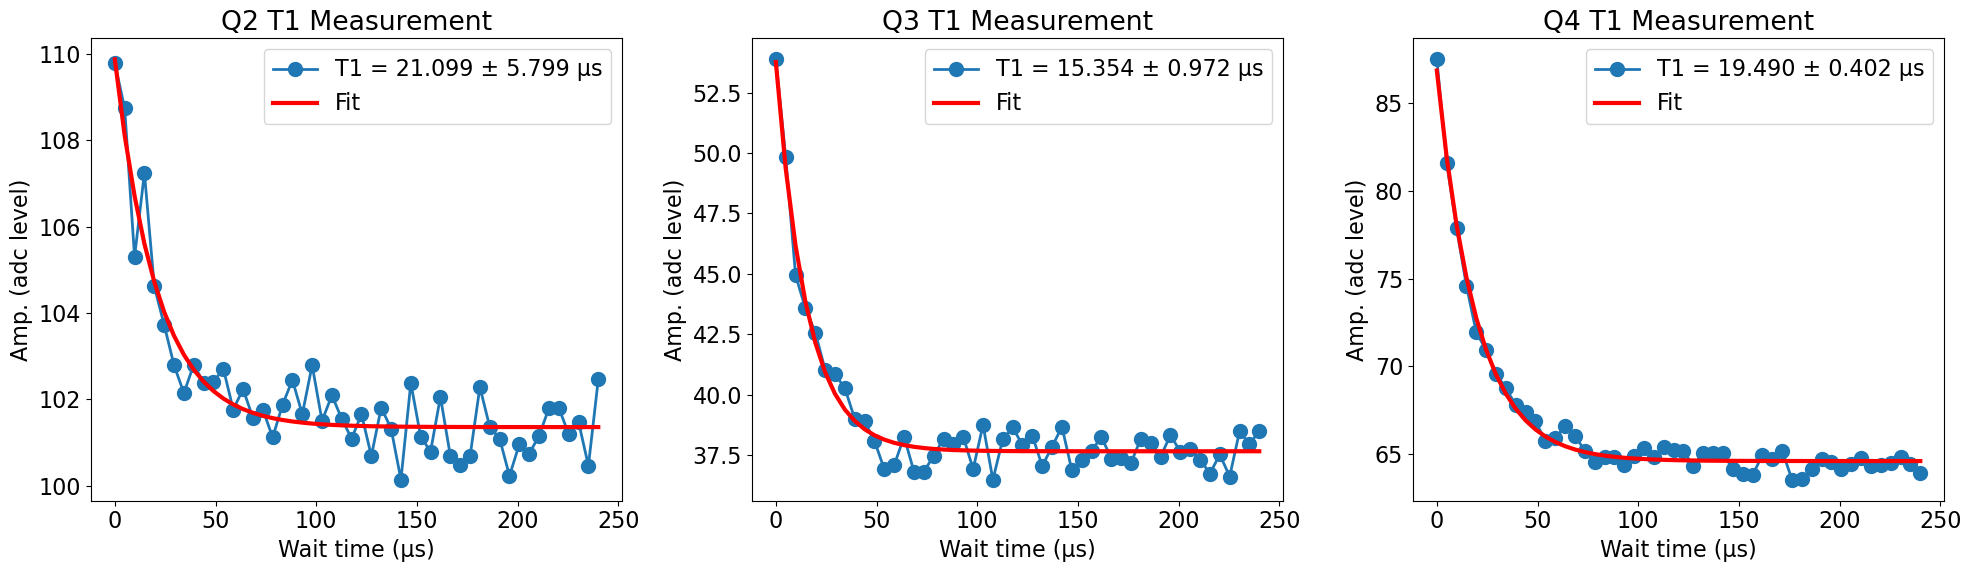

In [702]:
# Set up the figure 
plt.figure(figsize=(20, 6))
# Increase the font size
plt.rcParams.update({'font.size': 16})

# Create subplots
# plt.subplot(131)
# plt.plot(t_vec_corrected, amp1, 'o-', linewidth=2, markersize=10, label=f"T1 = {q1_popt[2]:.3f} ± {q1_pcov[2][2]:.3f} µs")
# plt.plot(t_vec_corrected, q1_fit_exponential, '-', color='red', linewidth=3, label="Fit")
# plt.xlabel("Wait time (µs)")
# plt.ylabel("Amp. (adc level)")
# plt.legend()
# plt.title("Q1 T1 Measurement")

plt.subplot(131)
plt.plot(t_vec_corrected, amp2, 'o-', linewidth=2, markersize=10, label=f"T1 = {q2_popt[2]:.3f} ± {q2_pcov[2][2]:.3f} µs")
plt.plot(t_vec_corrected, q2_fit_exponential, '-', color='red', linewidth=3, label="Fit")
plt.xlabel("Wait time (µs)")
plt.ylabel("Amp. (adc level)")
plt.legend()
plt.title("Q2 T1 Measurement")

plt.subplot(132)
plt.plot(t_vec_corrected, amp3, 'o-', linewidth=2, markersize=10, label=f"T1 = {q3_popt[2]:.3f} ± {q3_pcov[2][2]:.3f} µs")
plt.plot(t_vec_corrected, q3_fit_exponential, '-', color='red', linewidth=3, label="Fit")
plt.xlabel("Wait time (µs)")
plt.ylabel("Amp. (adc level)")
plt.legend()
plt.title("Q3 T1 Measurement")

plt.subplot(133)
plt.plot(t_vec_corrected, amp4, 'o-', linewidth=2, markersize=10, label=f"T1 = {q4_popt[2]:.3f} ± {q4_pcov[2][2]:.3f} µs")
plt.plot(t_vec_corrected, q4_fit_exponential, '-', color='red', linewidth=3, label="Fit")
plt.xlabel("Wait time (µs)")
plt.ylabel("Amp. (adc level)")
plt.legend()
plt.title("Q4 T1 Measurement")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [703]:

savepath = '/home/nexusadmin/qick/NEXUS_sandbox/Data'
date = '080624'

saveparams={"res_len": readout_cfg["ro_length"],
            "sigma": expt_cfg["q1_sigma"],
           "res_freq": readout_cfg["res_freqs"], #array of 4 center frequencies
            "qcenter": qcenter,
           "res_gains": readout_cfg["res_gains"],
           "reps": expt_cfg["reps"],
           "rounds": expt_cfg["rounds"],
           "q1_pi_amp":expt_cfg["q1_pi_amp"],
           "q2_pi_amp":expt_cfg["q2_pi_amp"],
           "q3_pi_amp":expt_cfg["q3_pi_amp"],
           "q4_pi_amp":expt_cfg["q4_pi_amp"]
           }

np.savez(f"{savepath}/{date}/QubitT1_234_resAtten(8,30)_qAtten(2,5)", cycle_sweep = expt_pts, us_sweep = t_vec_corrected, 
         amp1 = amps1, amp2 = amps2, amp3 = amps3, amp4 = amps4, expt_settings = saveparams)

# Ramsey

In [857]:
#detune by 1MHz --> fringe every 1us
class RamseyProgram(RAveragerProgram):
    def initialize(self):
        cfg = self.cfg
        
        # Set up multiplexed readout DAC
        self.declare_gen(ch=self.cfg["res_ch"], nqz=self.cfg["res_nqz"],
                        mux_freqs = self.cfg["res_freqs"],
                        mux_gains = self.cfg["res_gains"])
        
        # Set up 4 qubit pulses
        self.declare_gen(ch=self.cfg["q1_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 1
        self.declare_gen(ch=self.cfg["q2_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 2
        self.declare_gen(ch=self.cfg["q3_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 3
        self.declare_gen(ch=self.cfg["q4_ch"], nqz=self.cfg["qubit_nqz"], mixer_freq=self.cfg["mix_freq"]) # Qubit 4
        
        # Save register page for each qubit
        self.q1_rp=self.ch_page(self.cfg["q1_ch"]) # register page for qubit 1
        self.q2_rp=self.ch_page(self.cfg["q2_ch"]) # register page for qubit 2
        self.q3_rp=self.ch_page(self.cfg["q3_ch"]) # register page for qubit 3
        self.q4_rp=self.ch_page(self.cfg["q4_ch"]) # register page for qubit 4

        ## Specific to Ramsey measurement
        self.r_wait = 3
        self.regwi(self.q1_rp, self.r_wait, self.us2cycles(self.cfg["start"]))
        self.regwi(self.q2_rp, self.r_wait, self.us2cycles(self.cfg["start"]))
        self.regwi(self.q3_rp, self.r_wait, self.us2cycles(self.cfg["start"]))
        self.regwi(self.q4_rp, self.r_wait, self.us2cycles(self.cfg["start"]))
            
        # Back to the generic setup code for 4x qubits
        q1_ge = self.freq2reg(self.cfg["q1_freq"], gen_ch=self.cfg["q1_ch"])
        q2_ge = self.freq2reg(self.cfg["q2_freq"], gen_ch=self.cfg["q2_ch"])
        q3_ge = self.freq2reg(self.cfg["q3_freq"], gen_ch=self.cfg["q3_ch"])
        q4_ge = self.freq2reg(self.cfg["q4_freq"], gen_ch=self.cfg["q4_ch"])

        res_length = self.us2cycles(self.cfg["res_length"], gen_ch=self.cfg["res_ch"])
        self.set_pulse_registers(ch = self.cfg["res_ch"], style = 'const', length = res_length, mask=[0,1,2,3]) 

        self.add_gauss(ch=cfg["q1_ch"], name="qubit1", sigma=cfg["q1_sigma"], length=cfg["q1_sigma"]*4)
        self.add_gauss(ch=cfg["q2_ch"], name="qubit2", sigma=cfg["q2_sigma"], length=cfg["q2_sigma"]*4)
        self.add_gauss(ch=cfg["q3_ch"], name="qubit3", sigma=cfg["q3_sigma"], length=cfg["q3_sigma"]*4)
        self.add_gauss(ch=cfg["q4_ch"], name="qubit4", sigma=cfg["q4_sigma"], length=cfg["q4_sigma"]*4)

        self.set_pulse_registers(ch = self.cfg["q1_ch"], style = 'arb', freq = q1_ge, 
                                 phase = self.deg2reg(90, gen_ch=cfg["q1_ch"]),
                                gain = self.cfg['q1_pi2_amp'], waveform="qubit1")
        self.set_pulse_registers(ch = self.cfg["q2_ch"], style = 'arb', freq = q2_ge, 
                                 phase = self.deg2reg(90, gen_ch=cfg["q2_ch"]),
                                 gain = self.cfg['q2_pi2_amp'], waveform="qubit2")
        self.set_pulse_registers(ch = self.cfg["q3_ch"], style = 'arb', freq = q3_ge, 
                                 phase = self.deg2reg(90, gen_ch=cfg["q3_ch"]),
                                 gain = self.cfg['q3_pi2_amp'], waveform="qubit3")
        self.set_pulse_registers(ch = self.cfg["q4_ch"], style = 'arb', freq = q4_ge, 
                                 phase = self.deg2reg(90, gen_ch=cfg["q4_ch"]),
                                 gain = self.cfg['q4_pi2_amp'], waveform="qubit4")
             # Readout
        for i in range(0,4):
            self.declare_readout(ch      = self.cfg['ro_ch'][i],
                                 length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][i]),
                                 freq    = self.cfg['res_freqs'][i],
                                 gen_ch  = self.cfg['res_ch'])
   
        
        self.sync_all(self.us2cycles(1))
    
    def body(self):
        # Play qubit pulse
        self.pulse(ch = self.cfg["q1_ch"]) # play probe pulse
        self.pulse(ch = self.cfg["q2_ch"]) # play probe pulse
#       self.pulse(ch = self.cfg["q3_ch"]) # play probe pulse
        self.pulse(ch = self.cfg["q4_ch"]) # play probe pulse
        
        self.sync_all()
    
#        self.sync(self.q1_rp,self.r_wait)
#        self.sync(self.q2_rp,self.r_wait)
#        self.sync(self.q3_rp,self.r_wait)
        self.sync(self.q4_rp,self.r_wait)

        self.pulse(ch = self.cfg["q1_ch"]) # play probe pulse
        self.pulse(ch = self.cfg["q2_ch"]) # play probe pulse
#       self.pulse(ch = self.cfg["q3_ch"]) # play probe pulse
        self.pulse(ch = self.cfg["q4_ch"]) # play probe pulse
                
        self.sync_all()
        # trigger measurement (MUX), play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch        = self.cfg['res_ch'],
                     adcs            = self.ro_chs, #self.cfg["ro_ch"],
                     pins            = [0], # what is this?
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                     syncdelay       = self.us2cycles(self.cfg["relax_delay"]),
                     wait = True
                    )
        
    def update(self):
        self.mathi(self.q1_rp, self.r_wait, self.r_wait, '+', self.us2cycles(self.cfg["step"])) # update frequency list index
        self.mathi(self.q2_rp, self.r_wait, self.r_wait, '+', self.us2cycles(self.cfg["step"])) # update frequency list index
        self.mathi(self.q3_rp, self.r_wait, self.r_wait, '+', self.us2cycles(self.cfg["step"])) # update frequency list index
        self.mathi(self.q4_rp, self.r_wait, self.r_wait, '+', self.us2cycles(self.cfg["step"])) # update frequency list index


In [926]:
expt_cfg = {"start":0, "step":0.05, "expts":80, "reps": 2500, "rounds": 3, "relax_delay":100,
          "q1_pi2_amp": q1_pi2_amp, #14800
          "q2_pi2_amp": 0, #q2_pi2_amp,
          "q3_pi2_amp": 0, #q3_pi2_amp,
          "q4_pi2_amp": 0, #q4_pi2_amp,
          "q1_sigma"    : soc.us2cycles(0.02, gen_ch=ch_config["q1_ch"]),
          "q2_sigma"    : soc.us2cycles(0.02, gen_ch=ch_config["q2_ch"]),
          "q3_sigma"    : soc.us2cycles(0.02, gen_ch=ch_config["q3_ch"]),
          "q4_sigma"    : soc.us2cycles(0.02, gen_ch=ch_config["q4_ch"]),
          "q1_ch" : ch_config["q1_ch"],
          "q2_ch" : ch_config["q2_ch"],
          "q3_ch" : ch_config["q3_ch"],
          "q4_ch" : ch_config["q4_ch"],
          "q1_freq" : qcenter[0] - mixerfreq - 0.5, # Choose your detuning, here its set to 0.5 MHz
          "q2_freq" : qcenter[1] - mixerfreq - 0.5,
          "q3_freq" : qcenter[2] - mixerfreq + 1,
          "q4_freq" : qcenter[3] - mixerfreq + 0.5,
           }

config={**readout_cfg,**expt_cfg, **ch_config} #combine configs

config["res_gains"] = [G3,0,0,0]
print(config)

{'ro_length': 12.5, 'ro_offset': 0.5, 'res_length': 12.5, 'res_nqz': 2, 'qubit_nqz': 2, 'mix_freq': 4100, 'res_gains': [1, 0, 0, 0], 'res_freqs': [6187.93, 5828.32, 6600, 5959.28], 'start': 0, 'step': 0.05, 'expts': 80, 'reps': 2500, 'rounds': 3, 'relax_delay': 100, 'q1_pi2_amp': 15000, 'q2_pi2_amp': 0, 'q3_pi2_amp': 0, 'q4_pi2_amp': 0, 'q1_sigma': 9, 'q2_sigma': 9, 'q3_sigma': 9, 'q4_sigma': 9, 'q1_ch': 4, 'q2_ch': 5, 'q3_ch': 6, 'q4_ch': 7, 'q1_freq': 808.5, 'q2_freq': 648.5, 'q3_freq': 470, 'q4_freq': 659.5, 'res_ch': 15, 'ro_ch': [0, 1, 2, 3]}


In [927]:
ramsey = RamseyProgram(soccfg, config)

expt_pts, avgi, avgq = ramsey.acquire(soc,load_pulses=True, progress=True)
                            

  0%|          | 0/3 [00:00<?, ?it/s]

In [928]:
amp1 = np.abs(avgi[0][0]+1j*avgq[0][0])
amp2 = np.abs(avgi[1][0]+1j*avgq[1][0])
amp3 = np.abs(avgi[2][0]+1j*avgq[2][0])
amp4 = np.abs(avgi[3][0]+1j*avgq[3][0])

#Corrected t_vec
start_cycles = soc.us2cycles(config["start"])
step_cycles = soc.us2cycles(config["step"])
max_cycles = start_cycles + (config['expts']-1)*step_cycles
t_vec_corrected = np.linspace(soc.cycles2us(start_cycles), 
                (soc.cycles2us(max_cycles)), config['expts'], endpoint=False)

In [929]:
def decaying_cosine(x, a, b, c, d, e):
    return a * np.exp(-x / e) * np.cos(2. * np.pi * b * x + c * np.pi / 180.) + d

q1_a_guess = (np.max(amp1) - np.min(amp1)) / 2
q1_b_guess = 5 # Related to the detuning, # of fringes
q1_c_guess = 0
q1_d_guess = np.mean(amp1)
q1_e_guess = t_vec_corrected[-1]/4

q1_guess =[q1_a_guess, q1_b_guess, q1_c_guess, q1_d_guess, q1_e_guess]
q1_popt, q1_pcov = curve_fit(decaying_cosine, t_vec_corrected, amp1, maxfev = 100000, p0 = q1_guess)
q1_fit_decaying_cosine = decaying_cosine(t_vec_corrected, *q1_popt)

q2_a_guess = (np.max(amp2) - np.min(amp2)) / 2
q2_b_guess = 5 # Related to the detuning, # of fringes
q2_c_guess = 0
q2_d_guess = np.mean(amp2)
q2_e_guess = t_vec_corrected[-1]/4

q2_guess =[q2_a_guess, q2_b_guess, q2_c_guess, q2_d_guess, q2_e_guess]
q2_popt, q2_pcov = curve_fit(decaying_cosine, t_vec_corrected, amp2, maxfev = 100000, p0 = q2_guess)
q2_fit_decaying_cosine = decaying_cosine(t_vec_corrected, *q2_popt)

q3_a_guess = (np.max(amp3) - np.min(amp3)) / 2
q3_b_guess = 5 # Related to the detuning, # of fringes
q3_c_guess = 0
q3_d_guess = np.mean(amp3)
q3_e_guess = t_vec_corrected[-1]/4

q3_guess =[q3_a_guess, q3_b_guess, q3_c_guess, q3_d_guess, q3_e_guess]
q3_popt, q3_pcov = curve_fit(decaying_cosine, t_vec_corrected, amp3, maxfev = 100000, p0 = q3_guess)
q3_fit_decaying_cosine = decaying_cosine(t_vec_corrected, *q3_popt)

q4_a_guess = (np.max(amp4) - np.min(amp4)) / 2
q4_b_guess = 9 # Related to the detuning, # of fringes
q4_c_guess = 0
q4_d_guess = np.mean(amp4)
q4_e_guess = t_vec_corrected[-1]/4

q4_guess =[q4_a_guess, q4_b_guess, q4_c_guess, q4_d_guess, q4_e_guess]
q4_popt, q4_pcov = curve_fit(decaying_cosine, t_vec_corrected, amp4, maxfev = 100000, p0 = q4_guess)
q4_fit_decaying_cosine = decaying_cosine(t_vec_corrected, *q4_popt)


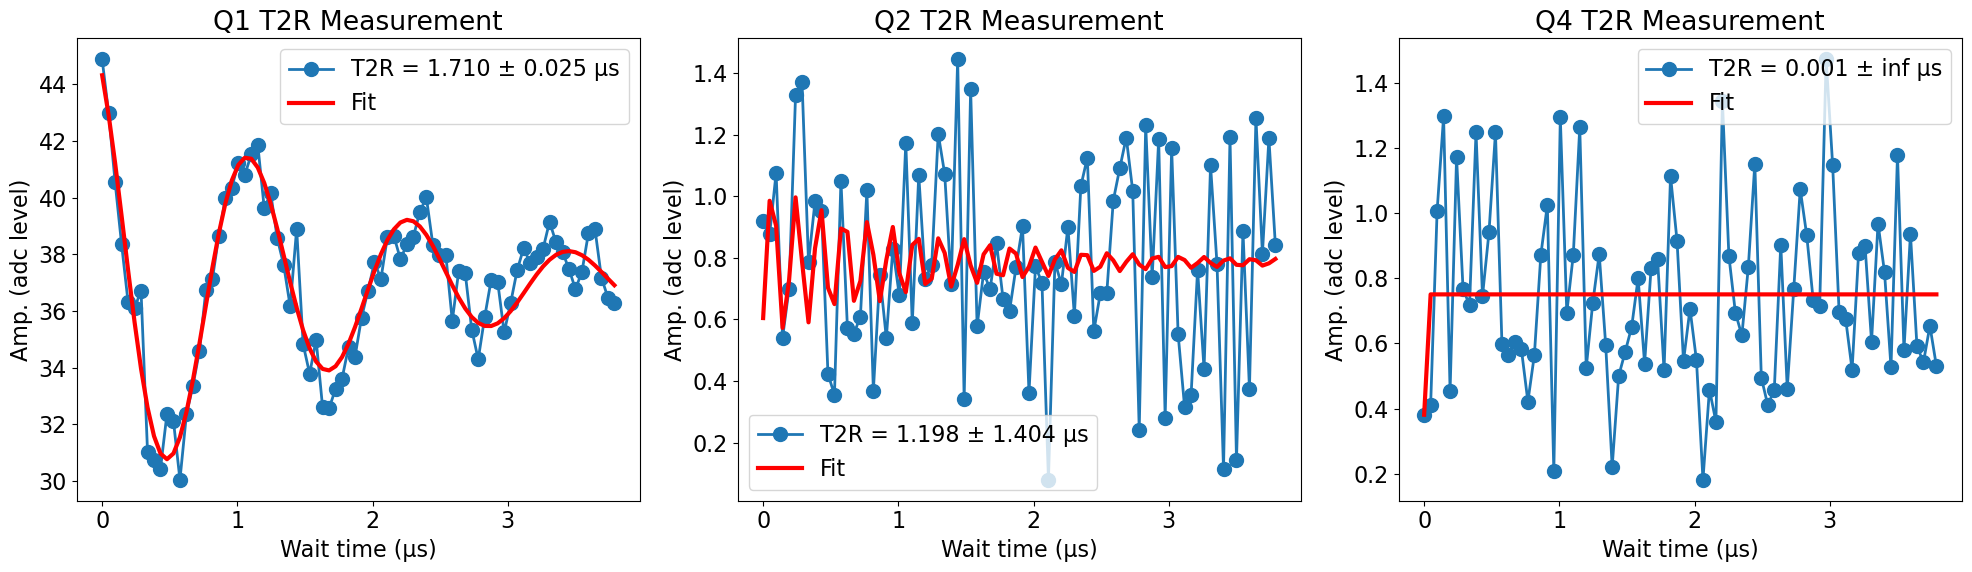

In [930]:
# Set up the figure 
plt.figure(figsize=(20, 6))
# Increase the font size
plt.rcParams.update({'font.size': 16})

# Create subplots
plt.subplot(131)
plt.plot(t_vec_corrected, amp1, 'o-', linewidth=2, markersize=10, label=f"T2R = {q1_popt[4]:.3f} ± {q1_pcov[4][4]:.3f} µs")
plt.plot(t_vec_corrected, q1_fit_decaying_cosine, '-', color='red', linewidth=3, label="Fit")
plt.xlabel("Wait time (µs)")
plt.ylabel("Amp. (adc level)")
plt.legend()
plt.title("Q1 T2R Measurement")

plt.subplot(132)
plt.plot(t_vec_corrected, amp2, 'o-', linewidth=2, markersize=10, label=f"T2R = {q2_popt[4]:.3f} ± {q2_pcov[4][4]:.3f} µs")
plt.plot(t_vec_corrected, q2_fit_decaying_cosine, '-', color='red', linewidth=3, label="Fit")
plt.xlabel("Wait time (µs)")
plt.ylabel("Amp. (adc level)")
plt.legend()
plt.title("Q2 T2R Measurement")

# plt.subplot(132)
# plt.plot(t_vec_corrected, amp3, 'o-', linewidth=2, markersize=10, label=f"T2R = {q3_popt[4]:.3f} ± {q3_pcov[4][4]:.3f} µs")
# plt.plot(t_vec_corrected, q3_fit_decaying_cosine, '-', color='red', linewidth=3, label="Fit")
# plt.xlabel("Wait time (µs)")
# plt.ylabel("Amp. (adc level)")
# plt.legend()
# plt.title("Q3 T2R Measurement")

plt.subplot(133)
plt.plot(t_vec_corrected, amp4, 'o-', linewidth=2, markersize=10, label=f"T2R = {q4_popt[4]:.3f} ± {q4_pcov[4][4]:.3f} µs")
plt.plot(t_vec_corrected, q4_fit_decaying_cosine, '-', color='red', linewidth=3, label="Fit")
plt.xlabel("Wait time (µs)")
plt.ylabel("Amp. (adc level)")
plt.legend()
plt.title("Q4 T2R Measurement")


# Adjust layout and display
plt.tight_layout()
plt.show()

In [931]:

savepath = '/home/nexusadmin/qick/NEXUS_sandbox/Data'
date = '080624'

saveparams={"res_len": readout_cfg["ro_length"],
            "q1_sigma": expt_cfg["q1_sigma"],
            "q2_sigma": expt_cfg["q2_sigma"],
            "q3_sigma": expt_cfg["q3_sigma"],
            "q4_sigma": expt_cfg["q4_sigma"],
           "res_freq": readout_cfg["res_freqs"], #array of 4 center frequencies
            "q1_freq": expt_cfg["q1_freq"],
            "q2_freq": expt_cfg["q2_freq"],
            "q3_freq": expt_cfg["q3_freq"],
            "q4_freq": expt_cfg["q4_freq"],
           "res_gains": readout_cfg["res_gains"],
           "reps": expt_cfg["reps"],
           "rounds": expt_cfg["rounds"],
           "q1_pi2_amp":expt_cfg["q1_pi2_amp"],
           "q2_pi2_amp":expt_cfg["q2_pi2_amp"],
           "q3_pi2_amp":expt_cfg["q3_pi2_amp"],
           "q4_pi2_amp":expt_cfg["q4_pi2_amp"]
           }

np.savez(f"{savepath}/{date}/QubitT2_1_resAtten(8,30)_qAtten(2,5)_Q2good_lessdetuned_Sara", cycle_sweep = expt_pts, us_sweep = t_vec_corrected, 
         amp1 = amps1, amp2 = amps2, amp3 = amps3, amp4 = amps4, expt_settings = saveparams)